In [6]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ssvep_analyzer import SsvepAnalyzer

from scipy.signal import cwt, morlet2

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [7]:
def read_file(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    return eeg_data, severity

def preprocess_data(eeg_data):
    analyzer = SsvepAnalyzer(sampling_rate=250, stimulus_frequency=16.5)
    eeg_data = analyzer.filter_extreme_values(eeg_data)
    eeg_data = analyzer.apply_linear_detrending(eeg_data)
    eeg_data = analyzer.apply_lowpass_filter(eeg_data)
    eeg_data = analyzer.apply_highpass_filter(eeg_data)
    eeg_data = analyzer.apply_notch_filter(eeg_data)
    reduced_eeg_data, _ = analyzer.compute_reduced_signal(eeg_data)
    return reduced_eeg_data

def build_dataset(directory_list):
    X = []
    y = []
    for directory in directory_list:
        for file in os.listdir('../Data/' + directory):
            file_path = '../Data/' + directory + '/' + file
            eeg_data, severity = read_file(file_path)
            reduced_eeg_data = preprocess_data(eeg_data)
            X.append(np.concatenate((reduced_eeg_data, np.zeros(6200 - len(reduced_eeg_data))))) # zero padding
            y.append(severity)
    return np.array(X), np.array(y)

directory_list = ['2024-01-06']

X, y = build_dataset(directory_list)

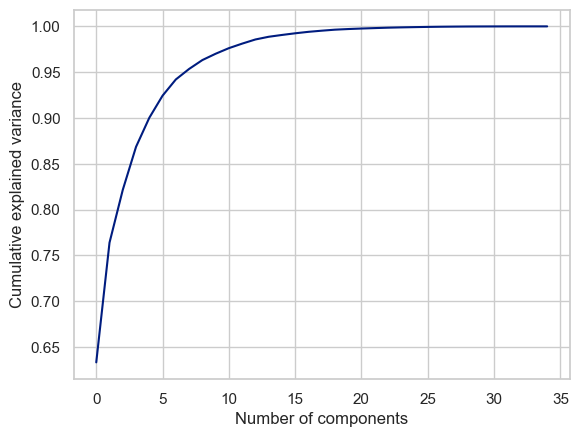

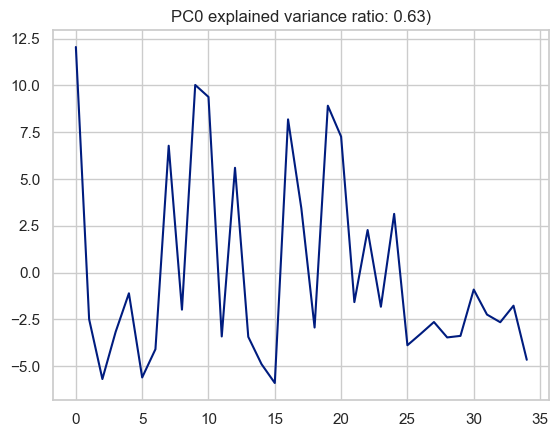

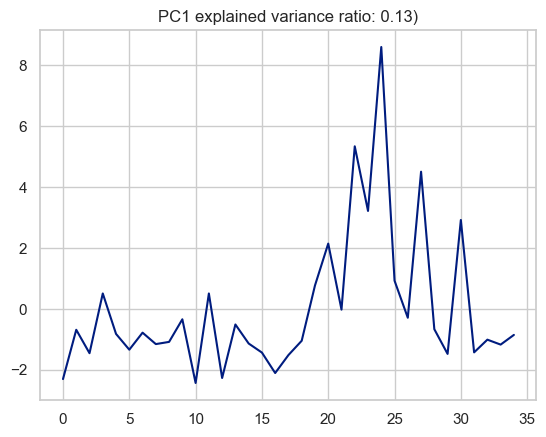

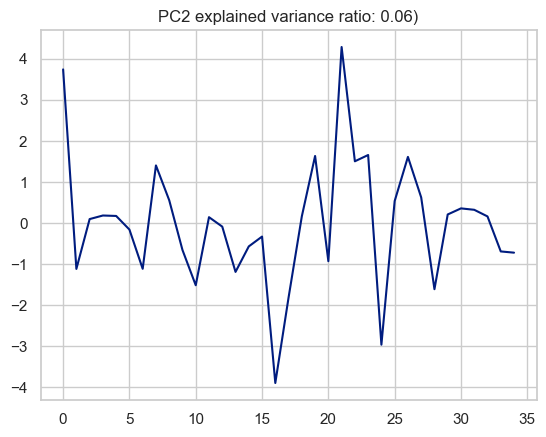

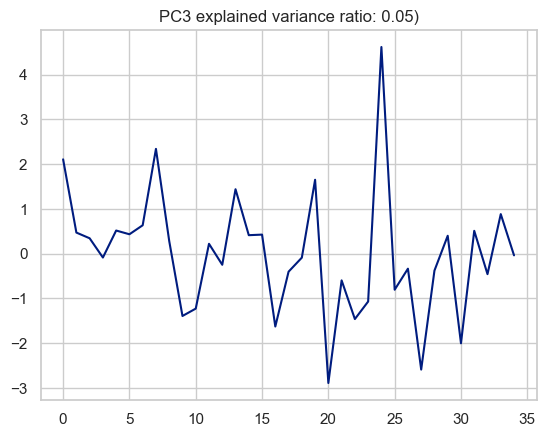

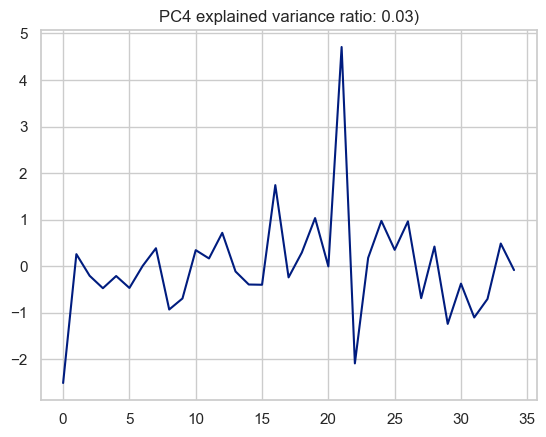

In [10]:
class WaveletTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, w=50, n_samples=100, sampling_rate=250, frequency=16.5):
        self.w = w
        self.n_samples = n_samples
        self.sampling_rate = sampling_rate
        self.frequency = frequency

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        width = self.w * self.sampling_rate / (2 * np.pi * self.frequency)
        cwt_matrix = np.apply_along_axis(lambda x: np.abs(cwt(x, morlet2, widths=[width], w=self.w, dtype='complex128')).flatten(), axis=1, arr=X)
        idx_mask = cwt_matrix.shape[1] // self.n_samples * np.arange(self.n_samples)
        cwt_matrix = cwt_matrix[:, idx_mask]
        return cwt_matrix

wavelet_transformer = WaveletTransformer()
pca = PCA()

X_fit = wavelet_transformer.fit_transform(X)
X_pca = pca.fit_transform(X_fit)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

for i in range(5):
    plt.plot(X_pca[:, i])
    plt.title(f'PC{i} explained variance ratio: {pca.explained_variance_ratio_[i]:.2f})' )
    plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.5)

pipeline = Pipeline([
    ('wavelet_transformer', WaveletTransformer(w=50, n_samples=200)),
    ('pca', PCA(n_components=7)),
    ('kernel_ridge', KernelRidge(alpha=1.0, kernel='rbf', gamma=0.1))
])

pipeline = pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
R2 = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
print(R2)

-0.030382403095393418
